<div style="background-color: #181818; padding: 5px; border-radius: 20px; text-align: center;">
    <h2 style="font-size: 1.7em;color:#FBFAFA">Disclaimer</h2>
</div> <br>
Most parts of this Jupyter Notebook were created in collaboration with ChatGPT-4o. This includes the following tasks: <br>
 - Debugging <br>
 - Improvement Suggestions<br>
 - Code implementation based on ideas from author<br>

However, this does not mean that all of it was generated by ChatGPT. The author still contributed with own written code, instructions, testing, improvement, and questions to bring this project further <br> 
The sections were ChatGPT was used for the major part are marked at the top with a comment #created with the help of ChatGPT

In [22]:
!pip install adaptkeybert datasets transformers sentence-transformers pandas keybert scikit-learn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [23]:
from transformers import pipeline, BertForSequenceClassification, BertTokenizer
from sentence_transformers import SentenceTransformer
from adaptkeybert import KeyBERT
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from transformers import AutoTokenizer
from nltk.corpus import stopwords
from gensim.parsing.preprocessing import STOPWORDS
import nltk

In [24]:
df_evaluation = pd.read_csv("evaluation_sentences.csv")

In [25]:
# Version 3.0 (Based on unsupervised list of LLaMA)

keywords_dict = {
    "Financial Performance": {
        "Earnings per Share": ["performance indicators","Earnings per Share expectations","price-to-earnings ratio"],
        "Cash Flow":["free cash flow","liquidity","working capital","cash reserves","FCF"],
        "Revenue": ["operational revenue", "business income", "operating profit","increased income","sales growth rate","earnings trajectory"],
        "Return on Equity": ["capital efficiency", "investment return", "capital ROI","ROE"],
        "Margins": ["EBITDA margins", "operating margin", "profit margin", "cost-to-revenue", "gross profit","profitability changes"],
        "Cost Management": ["expense control", "cost reduction", "efficiency savings","expense trimming", "cost containment","cost optimization","cost-effectiveness"],
        "Dividend Policy": ["dividend payout", "shareholder returns", "yield", "dividend sustainability", "payout ratio"],
        "Investments": ["strategic investment", "capital deployment", "fundraising", "fund allocation","capex"],
        "Balance Sheet": ["assets", "liabilities", "equity", "debt management", "financial health","book value","debt-to-equity ratio","equity issuance","capital structure"],
    },
    "Company": {
        "Long-term Growth": ["sustainable growth", "long-term trajectory", "future growth","scalability", "large-scale expansion","unit expansion","unit volume"],
        "Mergers and Acquisition": ["business acquisition", "M&A activity", "buyout approach","merger"],
        "Refranchising": ["franchise model", "franchise transitions", "refranchising plans"],
        "Sustainability": ["green initiatives", "environmental impact", "sustainable practices","ESG","SRI","sustainability","green energy adoption","social responsibility"],
        "Employees": ["workforce optimization","talent management","upskilling","remote work","employee management","employee benefits","diversity and inclusion","salary levels"],
        "Research and Development":["R&D spending","patent activity","technological breakthrough","future of work","continuous development","research projects"],
        "Marketing":["brand awareness","CI","corporate identity","performance marketing","brand loyalty","word-of-mouth","brand value","consumer perception"],
        "Shares Repurchase": ["buyback", "repurchase programs", "shareholder value", "equity reduction", "stock repurchases","stock rebuy"],
        "Processes":["process improvements","streamlined processes","productivity improvements","operational efficiency"],
        "Leadership":["effective leadership", "executive strength", "executive resilience","management trust","crisis management","risk assessment","contingency planning"],
    },
    "Product": {
        "Innovation": ["new features", "innovative products", "product advancements","new product","product launch","disruptive technology","portfolio diversification"],
        "Product Characteristics":["USP","unique selling point","product quality", "product differentiation","product portfolio"],
        "Pricing Strategy":["price segmentation","price optimization", "dynamic pricing", "competitive pricing","pricing models", "price elasticity", "discount strategies"],
        "Production": ["production capacities","manufacturing delays", "supply issues","production stops","factory problems","logistics bottlenecks","material shortage"],
        "Technology Trends":["autonomous systems","IoT (Internet of Things)", "machine learning","deep learning","natural language processing","AI","robotics","digital transformation","cloud computing","blockchain"]
    },
    "Market": {
        "Market Share": ["market share", "industry share", "market proportion","market penetration"],
        "Market Expansion": ["new markets", "geographical reach", "market entry","worldwide expansion"],
        "Competitors":["market rivalry", "competitive threats", "industry competition", "competitive advantage"],
        "Global Presence": ["international footprint", "global operations", "worldwide coverage"],
        "Industry Outlook":["sector growth","market trends","market evolution","industry trends"],
		"Regulations":["tax regulations","regulatory risks","governmental influence","government incentives", "state funding", "subsidies","political influence","legal disputes"],
        "Partnerships and Collaborations":["strategic alliances","partner relationships","joint venture"],
        "Supply Chain":["logistics optimization", "supply logistics", "supply chain strategies","supply constraints","inventory challenges","distribution channels", "supplier relationships","procurement"],
        "Economic Conditions": ["economic environment", "market economy", "macroeconomic factors","recession","expansion","inflationary impact","interest rate environment","foreign exchange impact"],
        "Demand":["increasing demand","decreasing demand","demand forecasting","consumer visits","store traffic"],
        "Customers": ["user interaction", "customer retention","customer loyalty","frequent buyer","user satisfaction","customer lifetime value (CLV)","per-visit spending","churn rate"]
    }
}

In [26]:
#Created with the help of ChatGPT
# Initialize KeyBERT and SentenceTransformer
kw_model = KeyBERT(zero_adapt=True)
sentence_transformer = SentenceTransformer('all-MiniLM-L6-v2')

# Initialize FinancialBERT for sentiment analysis
sentiment_model = BertForSequenceClassification.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis", num_labels=3)
tokenizer = BertTokenizer.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis")
financial_bert_sentiment = pipeline("sentiment-analysis", model=sentiment_model, tokenizer=tokenizer)

# Created with the help of ChatGPT
# Flatten the keywords into a single list for zero-shot KeyBERT
seed_words = [
    keyword
    for category, arguments in keywords_dict.items()
    for argument, keywords in arguments.items()
    for keyword in keywords
]

# Precompute embeddings for each argument's seed_words
precomputed_seed_embeddings = {
    argument: sentence_transformer.encode(seed_words)
    for category, arguments in keywords_dict.items()
    for argument, seed_words in arguments.items()
}

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Device set to use mps:0


In [27]:
kw_model.zeroshot_pre_train(
    domain_words=seed_words,
    adaptive_thr=0.25,
    minimal_similarity_zeroshot=0.65
)

In [28]:
#Created with the help of ChatGPT
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def truncate_text(text, max_length=512):
    encoded = tokenizer.encode(text, truncation=True, max_length=max_length, add_special_tokens=True)
    return tokenizer.decode(encoded, skip_special_tokens=True)

nltk.download('stopwords')

# Get the English stop words list
nltk_stopwords = stopwords.words('english')

# Print or use the stop words
print(nltk_stopwords)

# Convert the Gensim STOPWORDS set to a list (if needed)
gensim_stopwords = list(STOPWORDS)


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/oskarroeske/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
# Created with the help of ChatGPT
# Define the classification and analysis function
def classify_and_analyze(sentence, kw_model, keywords_dict, precomputed_seed_embeddings,seed_words, threshold=0.3):
    # Extract keywords with KeyBERT
    keywords = kw_model.extract_keywords(sentence, seed_keywords=seed_words,top_n=3,keyphrase_ngram_range=(1,2))
    extracted_keywords = [kw[0] for kw in keywords]

    current_max_score = 0
    selected_category = ""

    for category, arguments in keywords_dict.items():
        for argument, seed_words in arguments.items():
            # Use precomputed embeddings for the argument
            seed_embeddings = precomputed_seed_embeddings[argument]

            if len(extracted_keywords) == 0:
                continue  # Skip to the next category if no keywords are extracted

            keyword_embeddings = sentence_transformer.encode(extracted_keywords)
            if keyword_embeddings.shape[0] == 0 or seed_embeddings.shape[0] == 0:
                continue  # Skip computation if embeddings are empty

            if keyword_embeddings.shape[1] != seed_embeddings.shape[1]:
                print(f"Dimension mismatch: {keyword_embeddings.shape} vs {seed_embeddings.shape}")
                continue  # Skip incompatible embeddings

            # Compute cosine similarities
            similarities = cosine_similarity(keyword_embeddings, seed_embeddings)
            max_similarity = similarities.max() if similarities.size > 0 else 0
            if max_similarity >= threshold:
                if max_similarity > current_max_score:
                    current_max_score = max_similarity
                    selected_category = argument
    
    return selected_category


def truncate_text(text, max_length=512):
    encoded = tokenizer.encode(text, truncation=True, max_length=max_length, add_special_tokens=True)
    return tokenizer.decode(encoded, skip_special_tokens=True)

# Truncate sentence before passing it to the model
for idx, row in df_evaluation.iterrows():
    sentence = truncate_text(row['Sentence'], max_length=512)
    categories = classify_and_analyze(
        sentence, kw_model, keywords_dict, precomputed_seed_embeddings, seed_words
    )
    # Use FinancialBERT to classify sentiment
    sentiment_result = financial_bert_sentiment(sentence)[0]
    sentiment = sentiment_result['label']
    df_evaluation.at[idx, 'predicted_argument'] = categories
    df_evaluation.at[idx, 'predicted_sentiment'] = sentiment

# Argument Level

In [30]:
# Initialize counts
TP = 0  # True Positive
FP = 0  # False Positive
FN = 0  # False Negative
TN = 0  # True Negative
FP2 = 0 # False Postive 2

# Evaluate each row
for index, row in df_evaluation.iterrows():
    actual, predicted = row["Label"], row["predicted_argument"]
    if actual == predicted and not pd.isna(actual):
        TP += 1  # Correct argument assigned
    elif pd.isna(actual) and predicted == "":
        TN += 1  #no actual argument and none assigned
    elif not pd.isna(actual) and predicted == "":
        FN += 1  # No argument was assigned
    elif actual != predicted and pd.isna(actual):
        FP2 += 1  # Argument assigned when no should be
    elif actual != predicted:
        FP += 1  # Wrong argument assigned

# Print counts
print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"False Positives 2 (FP): {FP2}")
print(f"False Negatives (FN): {FN}")
print(f"True Negatives (TN): {TN}")

FP = FP + FP2

# Calculate precision, recall, and F1 score
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

True Positives (TP): 44
False Positives (FP): 79
False Positives 2 (FP): 26
False Negatives (FN): 1
True Negatives (TN): 0
Precision: 0.2953020134228188
Recall: 0.9777777777777777
F1 Score: 0.45360824742268036


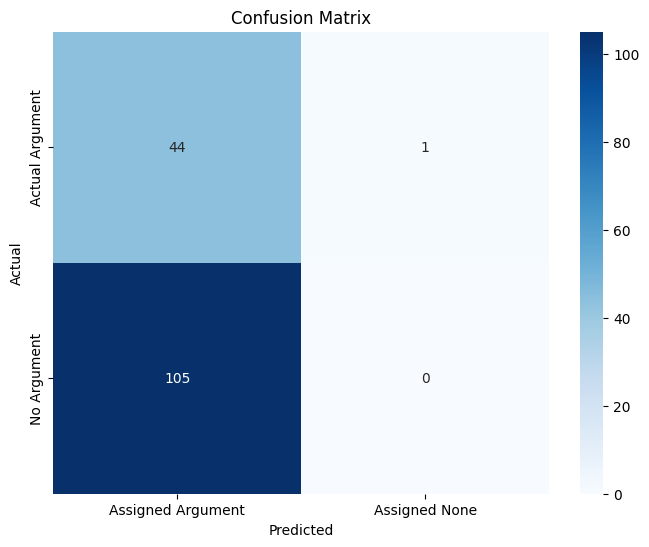

In [31]:
# Created with the help of ChatGPT
import matplotlib.pyplot as plt
import seaborn as sns  # optional for better heatmap visuals

# Data for the confusion matrix
confusion_data = {
    "Assigned Argument": [TP, FP],  # Predicted Argument Assigned
    "Assigned None": [FN, TN]       # Predicted None
}

confusion_matrix = pd.DataFrame(
    confusion_data, 
    index=["Actual Argument", "No Argument"]
)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")

# Add labels and title
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Category Level

In [32]:
# Created with the help of ChatGPT
# Step 1: Build reverse mapping
reverse_mapping = {}
for overall_category, subcategories in keywords_dict.items():
    for subcategory in subcategories:
        reverse_mapping[subcategory] = overall_category
# Step 2: Define lookup function
def get_overall_category(subcategory):
    return reverse_mapping.get(subcategory, "Unknown Category")


df_evaluation["actual_category"] = df_evaluation["Label"].apply(get_overall_category)
df_evaluation["predicted_category"] = df_evaluation["predicted_argument"].apply(get_overall_category)


In [33]:
# Initialize counts
TP_category = 0  # True Positive
FP_category = 0  # False Positive
FP_category2 = 0  # False Positive
FN_category = 0  # False Negative
TN_category = 0  # True Negative

# Evaluate each row
for index, row in df_evaluation.iterrows():
    actual_category, predicted_category = row["actual_category"], row["predicted_category"]
    if actual_category == predicted_category and actual_category != "Unknown Category":
        TP_category += 1  # Correct argument assigned
    elif actual_category == "Unknown Category" and predicted_category == "Unknown Category":
        TN_category += 1  # No cateogry was given and none was predicted
    elif actual_category != "Unknown Category" and predicted_category == "Unknown Category":
        FN_category += 1  # No argument was assigned
    elif actual_category != predicted_category and actual_category == "Unknown Category":
        FP_category2 += 1  # Argument assigned when no should be
    elif actual_category != predicted_category:
        FP_category += 1  # Wrong argument assigned

# Print counts
print(f"True Positives (TP): {TP_category}")
print(f"False Positives (FP): {FP_category}")
print(f"False Positives 2 (FP): {FP_category2}")
print(f"False Negatives (FN): {FN_category}")
print(f"True Negatives (TN): {TN_category}")

FP_category = FP_category + FP_category2

# Calculate precision_category, recall_category, and F1_category score
precision_category = TP_category / (TP_category + FP_category) if (TP_category + FP_category) > 0 else 0
recall_category = TP_category / (TP_category + FN_category) if (TP_category + FN_category) > 0 else 0
f1_category = 2 * (precision_category * recall_category) / (precision_category + recall_category) if (precision_category + recall_category) > 0 else 0

print(f"Precision_category: {precision_category}")
print(f"Recall_category: {recall_category}")
print(f"F1_category Score: {f1_category}")


True Positives (TP): 74
False Positives (FP): 49
False Positives 2 (FP): 26
False Negatives (FN): 0
True Negatives (TN): 1
Precision_category: 0.4966442953020134
Recall_category: 1.0
F1_category Score: 0.6636771300448431


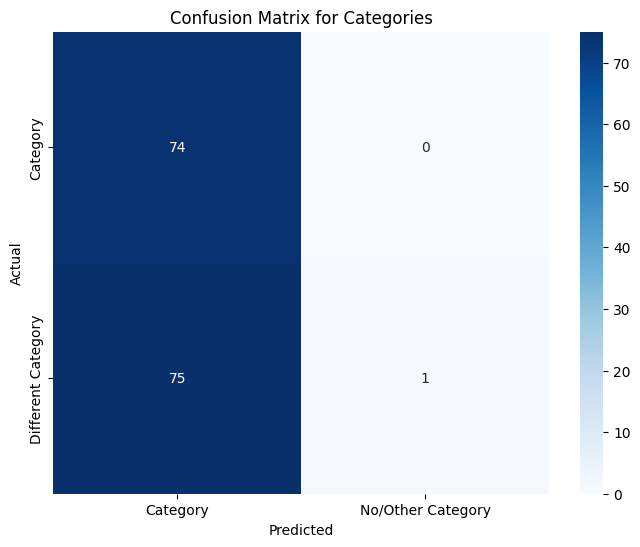

In [34]:
# Created with the help of ChatGPT
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Confusion matrix data
confusion_data_category = {
    "Category": [TP_category, FP_category],
    "No/Other Category": [FN_category, TN_category]    
}

# Create a DataFrame for the confusion matrix
confusion_matrix_category = pd.DataFrame(
    confusion_data_category, 
    index=["Category", "Different Category"]  # Row labels
)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_category, annot=True, fmt="d", cmap="Blues")

# Add labels and title
plt.title("Confusion Matrix for Categories")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# FinancialBERT 

In [35]:
TP_sentiment = 0
FP_sentiment = 0

# Evaluate each row
for index, row in df_evaluation.iterrows():
    actual_sentiment, predicted_sentiment = row["Sentiment"], row["predicted_sentiment"]
    if actual_sentiment == predicted_sentiment:
        TP_sentiment += 1  # Correct argument assigned
    else:
        FP_sentiment += 1


# Calculate precision_category, recall_category, and F1_category score
accuracy_sentiment = TP_sentiment / (TP_sentiment + FP_sentiment)

print(f"TP_sentiment: {TP_sentiment}")
print(f"FP_sentiment: {FP_sentiment}")
print(f"accuracy_sentiment: {accuracy_sentiment}")


TP_sentiment: 95
FP_sentiment: 55
accuracy_sentiment: 0.6333333333333333
